# EX11. 프로젝트 : 폐렴아 기다려라!
### 폐렴을 진단해보고 폐렴 진단기 성능개선 해보는 프로젝트
----------------------------------

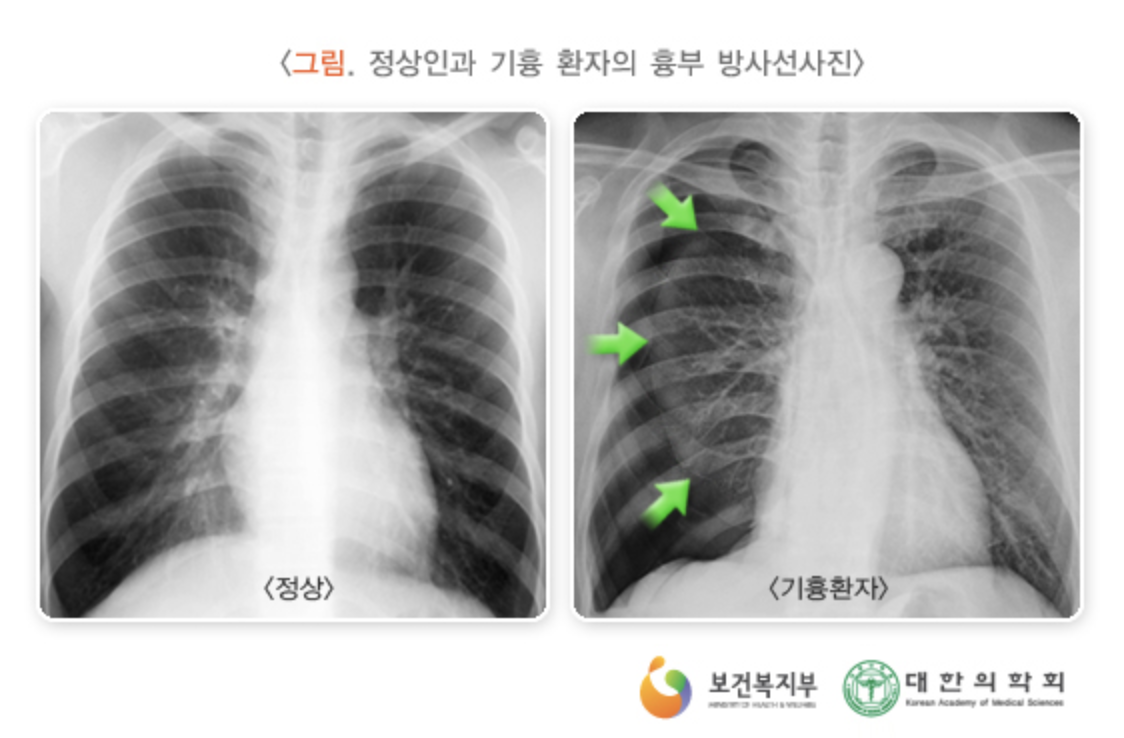


## X-RAY 영상을 촬영하기 위해 사용되는 자세 분류

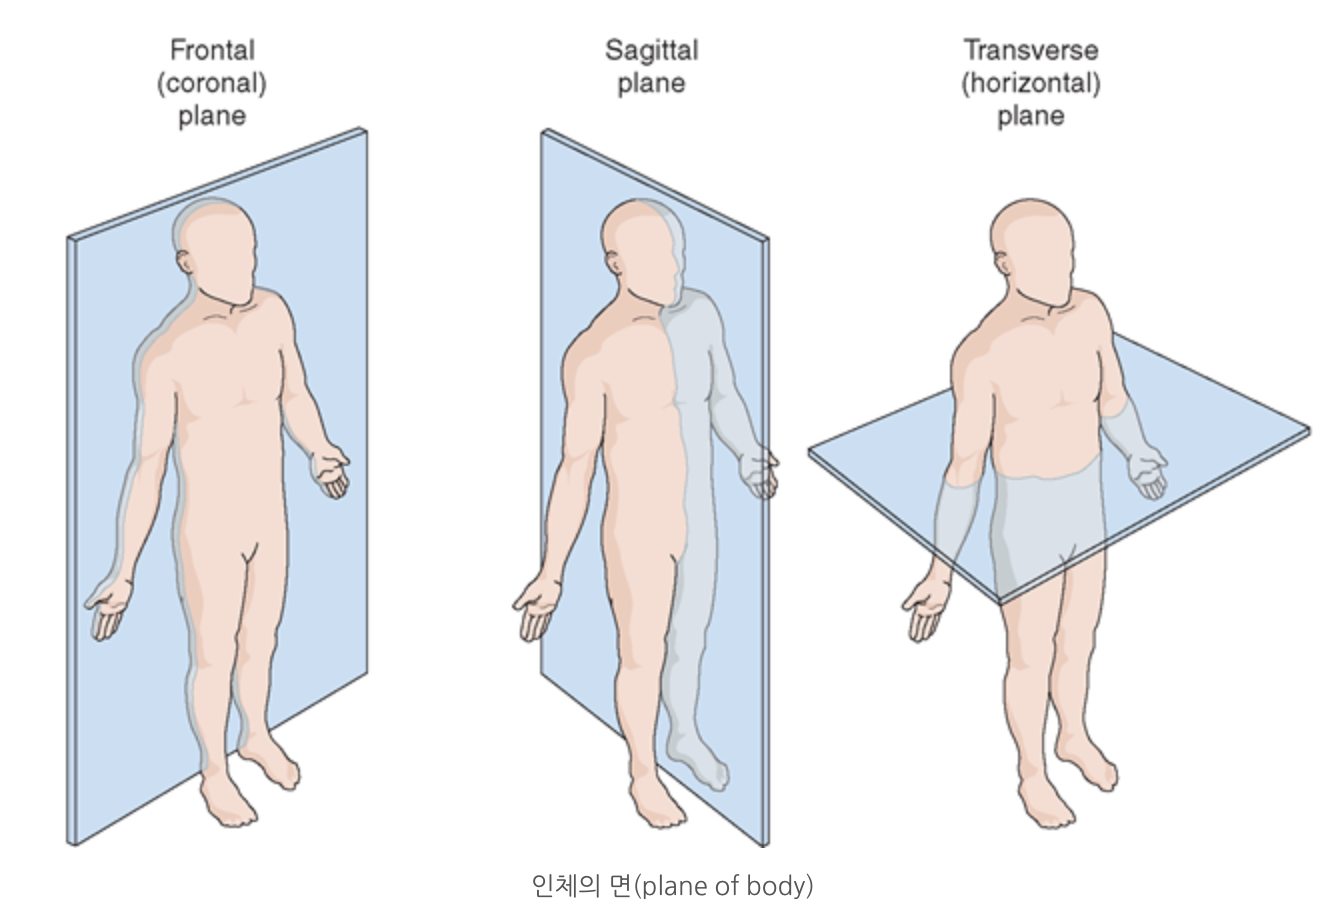
[참고](https://blog.naver.com/PostView.nhn?blogId=bagj97&logNo=221223459080&categoryNo=16&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)

#### * Sagittal plane : 시상면. 사람을 왼쪽과 오른쪽을 나누는 면.

#### * Coronal plane : 관상면. 인체를 앞뒤로 나누는 면.

#### * Transverse plane : 횡단면(수평면). 인체를 상하로 나누는 면.

### 오늘 사용할 데이터는 모두 관상면 이미지로 되어 있음
------------------

# ✅ 목차
-----------------------------
#### Step 1. 실험환경 Set-up   

#### Step 2. 데이터 가져오기    

#### Step 3. 데이터 시각화    

#### Step 4. CNN 모델링    

#### Step 5. 데이터 imbalance 처리    

#### Step 6. 모델 훈련    

#### Step 7. 결과 확인과 시각화    

#### Step8. 모델 평가하기

#### Step9. 폐렴 진단기 성능개선

---------------------------------

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray2/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray2/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray2/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)


/aiffel/aiffel


## Step 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


5216
624
16


train : 5216, test : 624, validation : 16 | 개수비는 89%,10.7%,0.3% validation 개수가 적어서 데이터 더 가져오기

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))


4185
1047


### train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인하기

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')


Normal image path
/aiffel/aiffel/chest_xray2/data/train/NORMAL/IM-0614-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray2/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


Normal images count in training set: 1070
Pneumonia images count in training set: 3115


위에 결과를 보면 폐렴이미지가 정상이미지보다 3배 더 많이 있음 \
다음 단계에서 사용할 CNN모델의 경우 데이터가 클래스별 balance가 좋으면 좋을수록 training을 잘함 - 차후에 조정해야함 \
(test와 val데이터셋은 평가하기 위해 사용하는거라 imbalance해도 상관없음)

In [7]:
# tf.data는 tensorflow에서 학습 시킬 때 배치처리 작업을 효율적으로 할 수 있음
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


In [8]:
# train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


Training images count: 4185
Validating images count: 1047


In [9]:
# 라벨 데이터 만들어주는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


In [10]:
# 이미지 데이터 사이즈가 제각각일 수 있어서 이미지 사이즈 통일 시키고
# GPU 메모리를 효율적으로 사용하기 위해서 이미지 사이즈 줄여보기
# 이미지를 알맞은 형식으로 바꿈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


In [11]:
# train 데이터셋과 val데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) # 초기화한 AUTOTUNE을 이용하면 더 빠르게 데이터 처리가능
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


#### 이미지가 resize가 잘 됐는지, label이 잘 들어가 있는지 확인

In [12]:
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    

Image shape:  (180, 180, 3)
Label:  False


#### 위와 같이 test 데이터셋도 만들기

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 개수 확인
print(TEST_IMAGE_COUNT)

624


In [14]:
# prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줌
def prepare_for_training(ds, shuffle_buffer_size=1000): # shuffle(): 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() # repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, repeat을 사용하면 여러번 데이터셋 사용가능
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # prefetch(): 학습 데이터를 나눠서 읽어오기 때문에 리소스의 유휴 상태를 줄일 수 있음
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

### 기존 train_ds 시각화

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


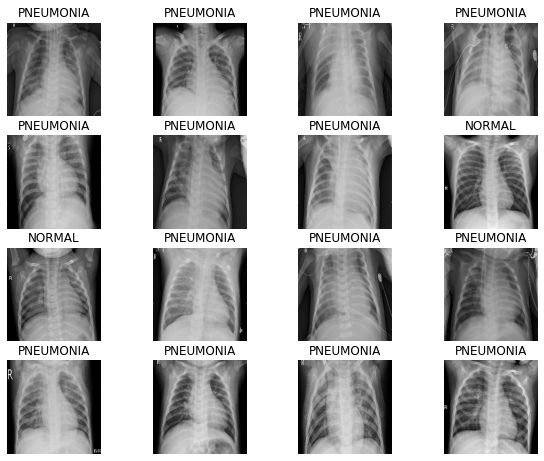

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE): # train에 있는 batch 중 첫 번째 배치를 추출해서 추출된 배치를 이미지와 라벨 데이터셋으로 나눔
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())
print(train_ds)

## Step 4. CNN 모델링

In [16]:
# 구성은 Convolution을 두번 진행하고 
# Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
# MaxPooling하기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 56s 144ms/step - loss: 0.4644 - accuracy: 0.7503 - precision: 0.9354 - recall: 0.7101 - val_loss: 0.6855 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 134ms/step - loss: 0.2561 - accuracy: 0.9035 - precision: 0.9745 - recall: 0.8958 - val_loss: 1.1605 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 134ms/step - loss: 0.2191 - accuracy: 0.9180 - precision: 0.9775 - recall: 0.9118 - val_loss: 0.1348 - val_accuracy: 0.9490 - val_precision: 0.9404 - val_recall: 0.9934
Epoch 4/25
261/261 [==============================] - 35s 134ms/step - loss: 0.1862 - accuracy: 0.9320 - precision: 0.9807 - recall: 0.9283 - val_loss: 0.2270 - val_accuracy: 0.8942 - val_precision: 0.8756 - val_recall: 0.9974
Epoch 5/25
261/261 [==============================] - 35s 134ms/step - loss: 0.1624 - accura

## Step 7. 결과 확인과 시각화

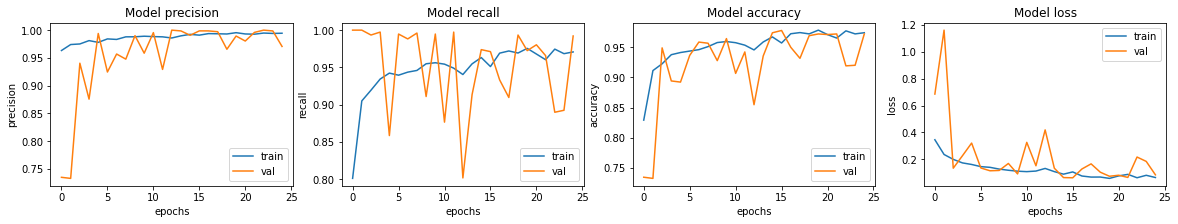

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step8. 모델 평가하기

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 1.8050 - accuracy: 0.7196 - precision: 0.6903 - recall: 1.0000
Loss: 1.8050484657287598,
Accuracy: 0.7195512652397156,
Precision: 0.6902654767036438,
Recall: 1.0


recall값은 높지만 accuracy값은 조금 낮아서 올려보도록 하자

## Step9. 폐렴 진단기 성능개선

In [24]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않기때문에 이를 극복할 수 있는 방법으로
**augmentation 기법**을 고려

In [35]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤 좌우반전
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2) # data augmentation 과정 추가
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds_aug = prepare_for_training(train_ds)
val_ds_aug = prepare_for_training(val_ds)

print(train_ds_aug)

<ParallelMapDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


### Augmentation 시각화

#### show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인

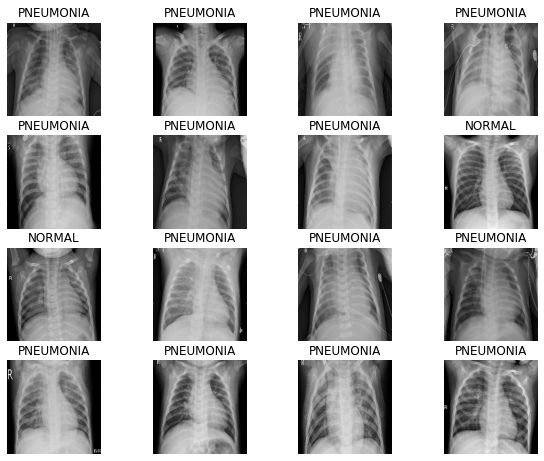

In [36]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE): # train에 있는 batch 중 첫 번째 배치를 추출해서 추출된 배치를 이미지와 라벨 데이터셋으로 나눔
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링

### Dropout을 쓰지 않고 해보기

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)    # dropout을 제거하고 실행해보기
    ])
    return block

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

### 모델훈련하기

In [39]:
with tf.device('/GPU:0'):
    model = build_model()
    
    # 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', # optimizer로 'adam'을 사용
        loss='binary_crossentropy', # 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
        metrics=METRICS
    )

### 먼저 recall을 기준으로 earlystopping해보기

[승환님 코드](https://github.com/RobotPoly/exploration/blob/main/%5BE-11%5DPneumonia/%5BE-11%5DPneumonia.ipynb) 참고하였습니다!

In [40]:
from keras.callbacks import EarlyStopping
# 최고의 정확도를 가질때 멈춰주는 함수 추가
es=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience=5)

In [41]:
EPOCHS = 35

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS, callbacks=[es],
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
261/261 [==============================] - 43s 140ms/step - loss: 0.3697 - accuracy: 0.8214 - precision: 0.9542 - recall: 0.7954 - val_loss: 0.5817 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 35s 135ms/step - loss: 0.2110 - accuracy: 0.9265 - precision: 0.9716 - recall: 0.9279 - val_loss: 1.2867 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 35s 135ms/step - loss: 0.1813 - accuracy: 0.9295 - precision: 0.9780 - recall: 0.9266 - val_loss: 0.4116 - val_accuracy: 0.8212 - val_precision: 0.8044 - val_recall: 1.0000
Epoch 4/35
261/261 [==============================] - 35s 135ms/step - loss: 0.1632 - accuracy: 0.9433 - precision: 0.9835 - recall: 0.9402 - val_loss: 0.2698 - val_accuracy: 0.8952 - val_precision: 1.0000 - val_recall: 0.8568
Epoch 5/35
261/261 [==============================] - 35s 135ms/step - loss: 0.1314 - accura

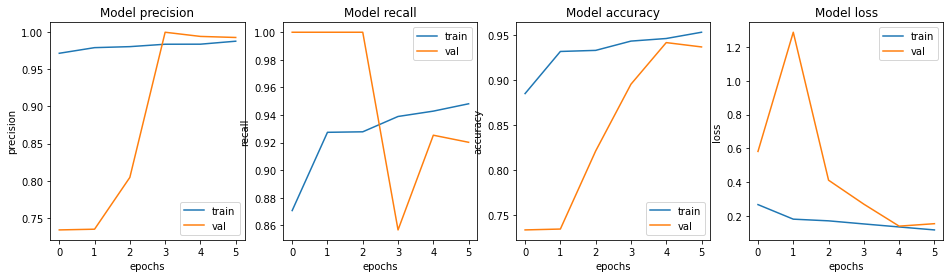

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [43]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 76ms/step - loss: 0.4146 - accuracy: 0.8670 - precision: 0.8449 - recall: 0.9641
Loss: 0.41464194655418396,
Accuracy: 0.8669871687889099,
Precision: 0.8449438214302063,
Recall: 0.964102566242218


accuracy도 중요하지만 의료영상에서는 recall값도 중요한 요소라서 recall값을 조금 더 올려보도록 하자

### Augmentation + Drop out 사용

In [47]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)    
    ])
    return block

In [48]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [49]:
with tf.device('/GPU:0'):
    model = build_model()
    
    # 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', # optimizer로 'adam'을 사용
        loss='binary_crossentropy', # 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
        metrics=METRICS
    )

###  precision을 기준으로 earlystopping해보기

In [50]:
from keras.callbacks import EarlyStopping
# 최고의 정확도를 가질때 멈춰주는 함수 추가
es=EarlyStopping(monitor='val_precision',mode='max',verbose=1,patience=5)

In [51]:
EPOCHS = 45

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS, callbacks=[es],
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/45
261/261 [==============================] - 43s 138ms/step - loss: 0.5714 - accuracy: 0.6972 - precision: 0.9016 - recall: 0.6632 - val_loss: 0.6460 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/45
261/261 [==============================] - 35s 135ms/step - loss: 0.2381 - accuracy: 0.8975 - precision: 0.9686 - recall: 0.8926 - val_loss: 1.2530 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/45
261/261 [==============================] - 35s 135ms/step - loss: 0.2299 - accuracy: 0.9203 - precision: 0.9720 - recall: 0.9188 - val_loss: 0.4699 - val_accuracy: 0.7788 - val_precision: 0.7684 - val_recall: 1.0000
Epoch 4/45
261/261 [==============================] - 35s 134ms/step - loss: 0.1922 - accuracy: 0.9272 - precision: 0.9773 - recall: 0.9244 - val_loss: 0.1213 - val_accuracy: 0.9529 - val_precision: 0.9588 - val_recall: 0.9777
Epoch 5/45
261/261 [==============================] - 35s 135ms/step - loss: 0.2081 - accura

In [52]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.8530 - accuracy: 0.7740 - precision: 0.7399 - recall: 0.9846
Loss: 0.8530037999153137,
Accuracy: 0.7740384340286255,
Precision: 0.7398843765258789,
Recall: 0.9846153855323792


recall값은 올라갔지만 accuracy는 떨어짐ㅠㅠ

### loss를 기준으로 earlystopping해보기

In [54]:
from keras.callbacks import EarlyStopping
# 최고의 정확도를 가질때 멈춰주는 함수 추가
es=EarlyStopping(monitor='val_loss',mode='max',verbose=1,patience=5)

In [55]:
EPOCHS = 60

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS, callbacks=[es],
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/60
261/261 [==============================] - 40s 136ms/step - loss: 0.1233 - accuracy: 0.9497 - precision: 0.9889 - recall: 0.9430 - val_loss: 0.0844 - val_accuracy: 0.9702 - val_precision: 0.9906 - val_recall: 0.9685
Epoch 2/60
261/261 [==============================] - 35s 135ms/step - loss: 0.1152 - accuracy: 0.9564 - precision: 0.9880 - recall: 0.9531 - val_loss: 0.2678 - val_accuracy: 0.8894 - val_precision: 0.9969 - val_recall: 0.8521
Epoch 3/60
261/261 [==============================] - 35s 135ms/step - loss: 0.1144 - accuracy: 0.9533 - precision: 0.9919 - recall: 0.9450 - val_loss: 0.1515 - val_accuracy: 0.9385 - val_precision: 0.9972 - val_recall: 0.9190
Epoch 4/60
261/261 [==============================] - 35s 135ms/step - loss: 0.1111 - accuracy: 0.9600 - precision: 0.9884 - recall: 0.9575 - val_loss: 14.9769 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 5/60
261/261 [==============================] - 35s 134ms/step - loss: 0.1859 - accur

In [56]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.4719 - accuracy: 0.8798 - precision: 0.8870 - recall: 0.9256
Loss: 0.47190162539482117,
Accuracy: 0.879807710647583,
Precision: 0.8869779109954834,
Recall: 0.9256410002708435


고루고루 높게 나온 것 같다.

# 🌟 루브릭 평가

|평가문항|상세문항|
|:------|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

1. 학습을 돌리고 나서 수치들을 그래프로 시각화하여 확인해봄
2. augmentation 기법도 고려해보고 drop out도 없애는 등 다양하게 학습해봄
3. accuracy가 85%넘음

# 🌟회고

데이터 imbalance 문제가 있을 때 이런 문제를 해결하는 방법으로 Weight balancing이라는 테크닉이 있다는 걸 알게되었고, 데이터가 많지 않을 때 augmentation기법도 고려해보면 좋다는 것도 알게 되어 의미있었던 exploration이었던 것 같다.

# 🌟 참고
[승환님코드](https://github.com/RobotPoly/exploration/blob/main/%5BE-11%5DPneumonia/%5BE-11%5DPneumonia.ipynb)